In [2]:
# For auto-reloading external modules see
# http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

import numpy
import observations.dimensions.two.sampling as observe
import matplotlib.pyplot as plt

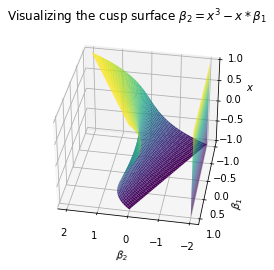

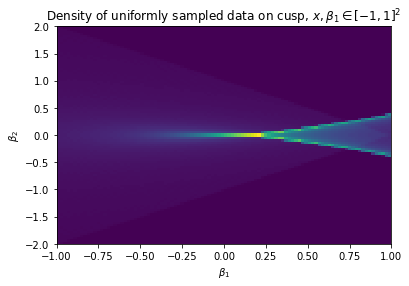

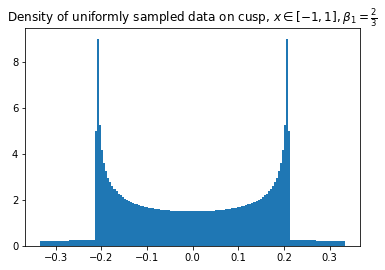

In [10]:
x_linespace = numpy.linspace(-1, 1, observe.samplesizex)
beta_1_linespace = numpy.linspace(-1, 1, observe.samplesizey)
X, beta_1 = numpy.meshgrid(x_linespace, beta_1_linespace)
beta_2 = observe.cusp_vectorized(X, beta_1)

fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.set_title(r'Visualizing the cusp surface $\beta_2 = x^3 - x*\beta_1$')
ax.plot_surface(beta_2, beta_1, X, cmap='viridis', edgecolor='none', rasterized=True)
ax.plot_surface(-2, beta_1, X, cmap='viridis', edgecolor='none', rasterized=True)
ax.set_xlabel(r'$\beta_2$')
ax.set_ylabel(r'$\beta_1$')
ax.set_zlabel('$x$')
ax.azim = 100
ax.elev = 35
plt.savefig("test.pdf", dpi=250)
plt.show()

plt.title(r"Density of uniformly sampled data on cusp, $x, \beta_1 \in [-1, 1]^2$")
plt.hist2d(beta_1.reshape(-1), beta_2.reshape(-1), bins=100, density=True)
plt.xlabel(r"$\beta_1$")
plt.ylabel(r"$\beta_2$")
plt.show()

plt.title(r"Density of uniformly sampled data on cusp, $x \in [-1, 1], \beta_1 = \frac{2}{3} $")
plt.hist(observe.cusp_vectorized(numpy.linspace(-1, 1, 100000), numpy.repeat(2/3, 100000)), density=True, bins=150)
plt.show()

# TODO: three dimensional density of 2d data?

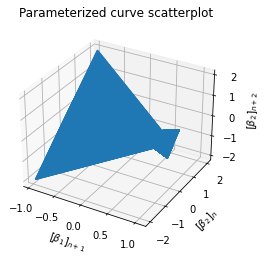

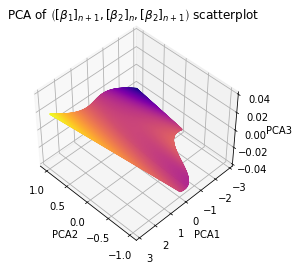

In [7]:
ys = observe.sample_beta_dir()

ax = plt.axes(projection='3d')
ax.scatter(numpy.transpose(ys)[0], numpy.transpose(ys)[1], numpy.transpose(ys)[2], s=0.5)
ax.set_xlabel("$[\\beta_1]_{n+1}$")
ax.set_ylabel("$[\\beta_2]_{n}$")
ax.set_zlabel("$[\\beta_2]_{n+2}$")
plt.title("Parameterized curve scatterplot")
plt.show()

from sklearn.decomposition import PCA
pca = PCA()
pca.n_components = 3

data = pca.fit_transform(ys)

ax = plt.axes(projection='3d')
plt.title("PCA of $\\left([\\beta_1]_{n+1}, [\\beta_2]_n, [\\beta_2]_{n+1}\\right)$ scatterplot")
ax.scatter(numpy.transpose(data)[1], numpy.transpose(data)[0], numpy.transpose(data)[2], c=numpy.transpose(data)[0], cmap='viridis', s = 0.5, rasterized=True)
ax.set_xlabel("PCA2")
ax.set_ylabel("PCA1")
ax.set_zlabel("PCA3")
ax.azim = 135
ax.elev = 45
plt.show()